![Sample Cat Images from Stable Diffusion](images/stable-diffusion-images-2.png)

## Background

Stable Diffusion, a very popular foundation model, is a text-to-image generative AI model capable of creating photorealistic images given any text input within tens of seconds. Qualcomm AI Research performed full-stack AI optimizations using the Qualcomm AI Stack to deploy Stable Diffusion on an Android smartphone for the very first time.


Stable Diffusion uses a latent diffusion model that iteratively applies denoising autoencoders. For a more computationally/memory efficient diffusion process, Stable Diffusion uses pretrained CLIP text encoder, U-Net, and variational autoencoder (VAE) models.
The Stable Diffusion model takes a latent seed and a text prompt as input. The latent seed is used to generate random latent pixel image representations.
* The text encoder transforms the text prompt to an embedding space that the U-Net can understand.
* The VAE compresses the image from pixel space to a smaller dimensional latent space to input to the U-Net model.
* U-Net iteratively denoises the random latent image representations while conditioning on the text embeddings to improve latent image representations that U-Net outputs.
* The VAE decoder generates the final image by translating the representation back into its original pixel space form.

The following figure shows how stable diffusion works during inference

![Stable Diffusion inference steps](images/stable_diffusion_architecture.png)

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size 64×64 where as the text prompt is transformed to text embeddings of size
77×768 via CLIP's text encoder.

Next the U-Net iteratively denoises the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. The denoising process is repeated ca. 50 times to step-by-step retrieve better latent image representations. Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## Setting up the environment

### Platform requirements
This notebook is intended to run on a machine with
- Machine running Ubuntu 20.04
- NVIDIA driver version equivalent to 525.60.13

### Installing package dependencies

1. Ensure that you have installed docker and nvidia docker2 runtime: https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html#docker.
2. Navigate to the folder containing this jupyter notebook and launch the container. See https://docs.qualcomm.com/bundle/publicresource/topics/80-64748-1/introduction.html for instructions on how to download this notebook.

    `docker run --rm --gpus all --name=aimet-dev-torch-gpu -v $PWD:$PWD -w $PWD -v /etc/localtime:/etc/localtime:ro -v /etc/timezone:/etc/timezone:ro --network=host --ulimit core=-1 --ipc=host --shm-size=8G --cap-add=SYS_PTRACE --security-opt seccomp=unconfined -it artifacts.codelinaro.org/codelinaro-aimet/aimet-dev:latest.torch-gpu`

    Alternatively, you can download and build AIMET docker using this Dockerfile: https://github.com/quic/aimet/blob/develop/Jenkins/Dockerfile.torch-gpu.

4. To install additional dependencies and start the jupyter server run the launch.sh script.
`./launch.sh`

5. Once the server has started you will be presented URL's to copy and paste into your browser.

6. From the jupyter home page select the stable_diffusion.ipynb.

## Loading the pre-trained FP32 models

Note that when this is run for the first time, these large model checkpoints (5-6GB) will be downloaded to the current folder on disk.

In [ ]:
import torch
from redefined_modules.transformers.models.clip.modeling_clip import CLIPTextModel
from redefined_modules.diffusers.models.unet_2d_condition import UNet2DConditionModel
from redefined_modules.diffusers.models.vae import AutoencoderKLDecoder

In [ ]:
cache_dir = "./_data_/cache/huggingface/diffusers"
device = 'cpu'
dtype = torch.float

print("Loading pre-trained TextEncoder model")
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',
                                             torch_dtype=dtype, cache_dir=cache_dir).to(device)
text_encoder.config.return_dict = False

print("Loading pre-trained UNET model")
unet = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5',
                                            subfolder="unet", revision='main', torch_dtype=dtype,
                                            cache_dir=cache_dir).to(device)
unet.config.return_dict = False

print("Loading pre-trained VAE model")
vae = AutoencoderKLDecoder.from_pretrained('runwayml/stable-diffusion-v1-5',
                                           revision='main', subfolder="vae", torch_dtype=dtype,
                                           cache_dir=cache_dir).to(device)
vae.config.return_dict = False


Next, unroll the multi-head attention (MHA) blocks in the model to individual single-head attention (SHA) blocks.

In [ ]:
from stable_diff_pipeline import run_the_pipeline, save_image, replace_mha_with_sha_blocks
replace_mha_with_sha_blocks(unet)

## Run a floating-point evaluation
Run an example prompt through the loaded FP32 model and check the generated image.

Saved generated.png


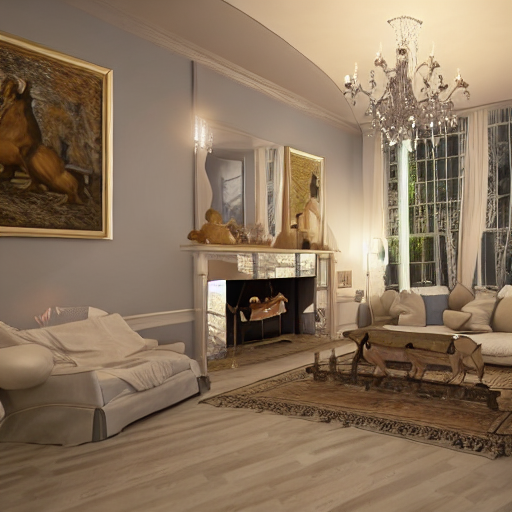

In [4]:
from transformers import CLIPTokenizer
from stable_diff_pipeline import run_tokenizer, run_text_encoder, run_diffusion_steps, run_vae_decoder
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', cache_dir=cache_dir)

prompt = "decorated modern country house interior, 8 k, light reflections"
image = run_the_pipeline(prompt, unet, text_encoder, vae, tokenizer, test_name='fp32', seed=1.36477711e+14)
save_image(image.squeeze(0), 'generated.png')

from IPython.display import Image, display
display(Image(filename='generated.png'))

**Example pre-quantization optimization result**

![Example result; decorated country house living room interior](./images/example_pre_quant.png)

## Apply AIMET quantization optimization techniques
Use the AI Model Efficiency Toolkit (AIMET) to create quantization simulation models (QuantSim) for the text encoder, U-Net, and VAE using a mixed-precision quantization scheme. A calibration process is used to create these QuantSim models where per-layer quantization encodings are determined using representative data samples. The QuantSim models simulate running the stable diffusion models on a quantized target. In addition, for the Text Encoder model, the AIMET Adaptive Rounding (AdaRound) technique is applied to get a boost in quantized accuracy.

Set the parameter bitwidth to INT8 and the activation bitwidth to INT16.

### Apply AIMET Adaptive Rounding (AdaRound) to the TE model
To help recover quantized accuracy of the TE model, apply the AIMET AdaRound optimization technique. AdaRound performs layer-by-layer optimization to learn a rounding matrix of how the layer weights get rounded.

Expected execution time: 19min

In [ ]:
import json
from argparse import Namespace
from aimet_quantsim import apply_adaround_te, calibrate_te

with open('config.json', 'rt') as f:
    config = Namespace(**json.load(f))

with open(config.calibration_prompts, "rt") as f:
    print(f'Loading prompts from {config.calibration_prompts}')
    prompts = f.readlines()
    prompts = prompts[:50]

tokens = [run_tokenizer(tokenizer, prompt) for prompt in prompts]

text_encoder_sim = apply_adaround_te(text_encoder, tokens, config)
del text_encoder
text_encoder = None

2024-05-31 21:05:33,057 - root - INFO - AIMET
Loading prompts from calibration_prompts.txt


/home/zhenghaoz/PycharmProjects/notebooks/aimet/redefined_modules/transformers/models/clip/modeling_clip.py:327: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/zhenghaoz/PycharmProjects/notebooks/aimet/redefined_modules/transformers/models/clip/modeling_clip.py:335: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
/home/zhenghaoz/PycharmProjects/notebooks/aimet/redefined_modules/transformers/models/clip/modeling_clip.py:3

2024-05-31 21:05:35,231 - Quant - INFO - No config file provided, defaulting to config file at /usr/local/lib/python3.8/dist-packages/aimet_common/quantsim_config/default_config.json
2024-05-31 21:05:35,264 - Quant - INFO - Unsupported op type Squeeze
2024-05-31 21:05:35,265 - Quant - INFO - Unsupported op type Pad
2024-05-31 21:05:35,265 - Quant - INFO - Unsupported op type Mean
2024-05-31 21:05:35,325 - Quant - INFO - Selecting DefaultOpInstanceConfigGenerator to compute the specialized config. hw_version:default
2024-05-31 21:05:37,014 - Utils - INFO - Caching 50 batches from data loader at path location: /tmp/adaround/


2024-05-31 21:05:37,118 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.0.self_attn.q_proj


2024-05-31 21:11:06,357 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.0.self_attn.k_proj


2024-05-31 21:16:36,096 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.0.self_attn.v_proj


2024-05-31 21:22:05,652 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.0.self_attn.out_proj


2024-05-31 21:27:37,988 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.0.mlp.fc1


2024-05-31 21:47:56,152 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.0.mlp.fc2


2024-05-31 22:06:14,663 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.1.self_attn.q_proj


2024-05-31 22:11:43,755 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.1.self_attn.k_proj


2024-05-31 22:17:15,789 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.1.self_attn.v_proj


2024-05-31 22:22:45,885 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.1.self_attn.out_proj


2024-05-31 22:28:28,979 - Quant - INFO - Started Optimizing weight rounding of module: text_model.encoder.layers.1.mlp.fc1


 15%|██████████▋                                                              | 27/184 [1:22:51<6:45:53, 155.12s/it]

### Calibrate the TE model
We use 20 prompts to calibrate the TE Quantization Sim (QuantSim) Model. Using more prompts may help increase the quantized accuracy, while taking proportionally more time for the calibration process itself.

In [ ]:
text_encoder_sim = calibrate_te(text_encoder_sim, tokens, config)

### Calibrate the UNET model
Next create a QuantSim model and calibrate the UNET.
Use the same prompts used for calibrating the TE model to generate embeddings that are used to calibrate the UNET model. The prompts are fed as inputs to the already-calibrated TE QuantSim model and the resulting embeddings are stored to use as calibration data for the UNET.

Expected execution time: 28min

In [ ]:
from aimet_quantsim import calibrate_unet

embeddings = [(run_text_encoder(text_encoder_sim.model, uncond),
               run_text_encoder(text_encoder_sim.model, cond)) for cond, uncond in tokens]
embeddings = [torch.cat([uncond, cond])for uncond, cond in embeddings]

unet_sim = calibrate_unet(unet, embeddings, config)

### Calibrate the VAE model
Next create a QuantSim model and calibrate the VAE.
The embeddings used in the previous step are fed as inputs to the already-calibrated UNET QuantSim model and the resulting latents are stored to use as calibration data for the VAE.

Expected execution time: 18min

In [ ]:
from aimet_quantsim import calibrate_vae
from tqdm.auto import tqdm

latents = [run_diffusion_steps(unet_sim.model, i) for i in tqdm(embeddings)]
print('Obtained latents using UNET QuantSim')

vae_sim = calibrate_vae(vae, latents, config)

## Running Quantized off-target Inference

With AIMET QuantSim versions of the text encoder, U-Net, and VAE models, the same pipeline can be used to run a simulated quantized inference of the Stable Diffusion model. Pass in the sim versions of the models. The rest of the pipeline is the same.

In [ ]:
image = run_the_pipeline(prompt, unet_sim.model, text_encoder_sim.model, vae_sim.model, tokenizer, test_name="int8", seed=1.36477711e+14)
save_image(image.squeeze(0), 'generated_after_quant.png')

display(Image(filename='generated_after_quant.png'))

**Example post-quantization optimization result**

![Example post-quantization optimization result; decorated living room interior](images/example_post_quant.png)

## Export the model
Model optimization using AIMET is complete. Export the model and the corresponding quantization encodings.

Expected execution time: 18m

In [ ]:
from aimet_quantsim import export_all_models

export_all_models(text_encoder_sim, unet_sim, vae_sim, tokens, embeddings, latents)

Copyright (c) 2023 Qualcomm Technologies, Inc. and/or its subsidiaries.